In [3]:
'''Clear out temporary variables and get a clean session'''
try:
    from IPython import get_ipython
    get_ipython().magic('clear')
    get_ipython().magic('reset -f')
except:
    pass

In [44]:
'''Import necessary libraries'''
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import pylab as pl
import seaborn as sns
import missingno as msno
from fancyimpute import KNN
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
from scipy.stats.mstats import winsorize
from scipy.stats import percentileofscore

%matplotlib inline

In [5]:
'''Read in churn data file'''
churn = pd.read_csv('churn_raw_data.csv')

In [6]:
churn.head()

,Unnamed: 0,CaseOrder,Customer_id,Interaction,City,State,County,Zip,Lat,Lng,...,MonthlyCharge,Bandwidth_GB_Year,item1,item2,item3,item4,item5,item6,item7,item8
0,1,1,K409198,aa90260b-4141-4a24-8e36-b04ce1f4f77b,Point Baker,AK,Prince of Wales-Hyder,99927,56.25100,-133.37571,...,171.449762,904.536110,5,5,5,3,4,4,3,4
1,2,2,S120509,fb76459f-c047-4a9d-8af9-e0f7d4ac2524,West Branch,MI,Ogemaw,48661,44.32893,-84.24080,...,242.948015,800.982766,3,4,3,3,4,3,4,4
2,3,3,K191035,344d114c-3736-4be5-98f7-c72c281e2d35,Yamhill,OR,Yamhill,97148,45.35589,-123.24657,...,159.440398,2054.706961,4,4,2,4,4,3,3,3
3,4,4,D90850,abfa2b40-2d43-4994-b15a-989b8c79e311,Del Mar,CA,San Diego,92014,32.96687,-117.24798,...,120.249493,2164.579412,4,4,4,2,5,4,3,3
4,5,5,K662701,68a861fd-0d20-4e51-a587-8a90407ee574,Needville,TX,Fort Bend,77461,29.38012,-95.80673,...,150.761216,271.493436,4,4,4,3,4,4,4,5


In [7]:
'''Drop the first unnamed column'''
churn.drop(['Unnamed: 0', 'CaseOrder'], axis = 1, inplace=True)

In [8]:
'''Get basic info about the DataFrame, esp. null values.'''
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 50 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Customer_id           10000 non-null  object 
 1   Interaction           10000 non-null  object 
 2   City                  10000 non-null  object 
 3   State                 10000 non-null  object 
 4   County                10000 non-null  object 
 5   Zip                   10000 non-null  int64  
 6   Lat                   10000 non-null  float64
 7   Lng                   10000 non-null  float64
 8   Population            10000 non-null  int64  
 9   Area                  10000 non-null  object 
 10  Timezone              10000 non-null  object 
 11  Job                   10000 non-null  object 
 12  Children              7505 non-null   float64
 13  Age                   7525 non-null   float64
 14  Education             10000 non-null  object 
 15  Employment          

In [9]:
'''Calculate percentage of null values in dataset'''
churn_nullity = churn.isnull()
churn_nullity.mean()*100

Customer_id              0.00
Interaction              0.00
City                     0.00
State                    0.00
County                   0.00
Zip                      0.00
Lat                      0.00
Lng                      0.00
Population               0.00
Area                     0.00
Timezone                 0.00
Job                      0.00
Children                24.95
Age                     24.75
Education                0.00
Employment               0.00
Income                  24.90
Marital                  0.00
Gender                   0.00
Churn                    0.00
Outage_sec_perweek       0.00
Email                    0.00
Contacts                 0.00
Yearly_equip_failure     0.00
Techie                  24.77
Contract                 0.00
Port_modem               0.00
Tablet                   0.00
InternetService          0.00
Phone                   10.26
Multiple                 0.00
OnlineSecurity           0.00
OnlineBackup             0.00
DeviceProt

In [10]:
'''Classify variables as objects'''
churn[['Zip', 'Lat', 'Lng']] = churn[['Zip', 'Lat', 'Lng']].astype('object')

In [11]:
'''Create lists with the names of columns that contain NaN values along with percentage of NaN values'''
churn_null = churn.isnull().sum()/churn.count()*100
churn_null_df = pd.DataFrame(churn_null, columns = ['Missing'])

churn_null_pct = []
churn_null_name = []
for index, data in churn_null_df.iterrows():
    if data[0] > 0:
        churn_null_pct.append(data[0])
        churn_null_name.append(index)
print (churn_null_name)
print (list(zip(churn_null_name, churn_null_pct)))

['Children', 'Age', 'Income', 'Techie', 'Phone', 'TechSupport', 'Tenure', 'Bandwidth_GB_Year']
[('Children', 33.24450366422385), ('Age', 32.89036544850498), ('Income', 33.15579227696405), ('Techie', 32.92569453675395), ('Phone', 11.433028749721418), ('TechSupport', 11.000111000111), ('Tenure', 10.265740434447016), ('Bandwidth_GB_Year', 11.370976723465864)]


In [12]:
'''View only columns with null values'''
churn[churn_null_name]

,Children,Age,Income,Techie,Phone,TechSupport,Tenure,Bandwidth_GB_Year
0,NaN,68.0,28561.99,No,Yes,No,6.795513,904.536110
1,1.0,27.0,21704.77,Yes,Yes,No,1.156681,800.982766
2,4.0,50.0,NaN,Yes,Yes,No,15.754144,2054.706961
3,1.0,48.0,18925.23,Yes,Yes,No,17.087227,2164.579412
4,0.0,83.0,40074.19,No,No,Yes,1.670972,271.493436
...,...,...,...,...,...,...,...,...
9995,3.0,NaN,55723.74,NaN,NaN,No,68.197130,6511.253000
9996,4.0,48.0,NaN,NaN,NaN,No,61.040370,5695.952000
9997,NaN,NaN,NaN,No,Yes,No,NaN,4159.306000
9998,1.0,39.0,16667.58,No,No,Yes,71.095600,6468.457000


<AxesSubplot:>

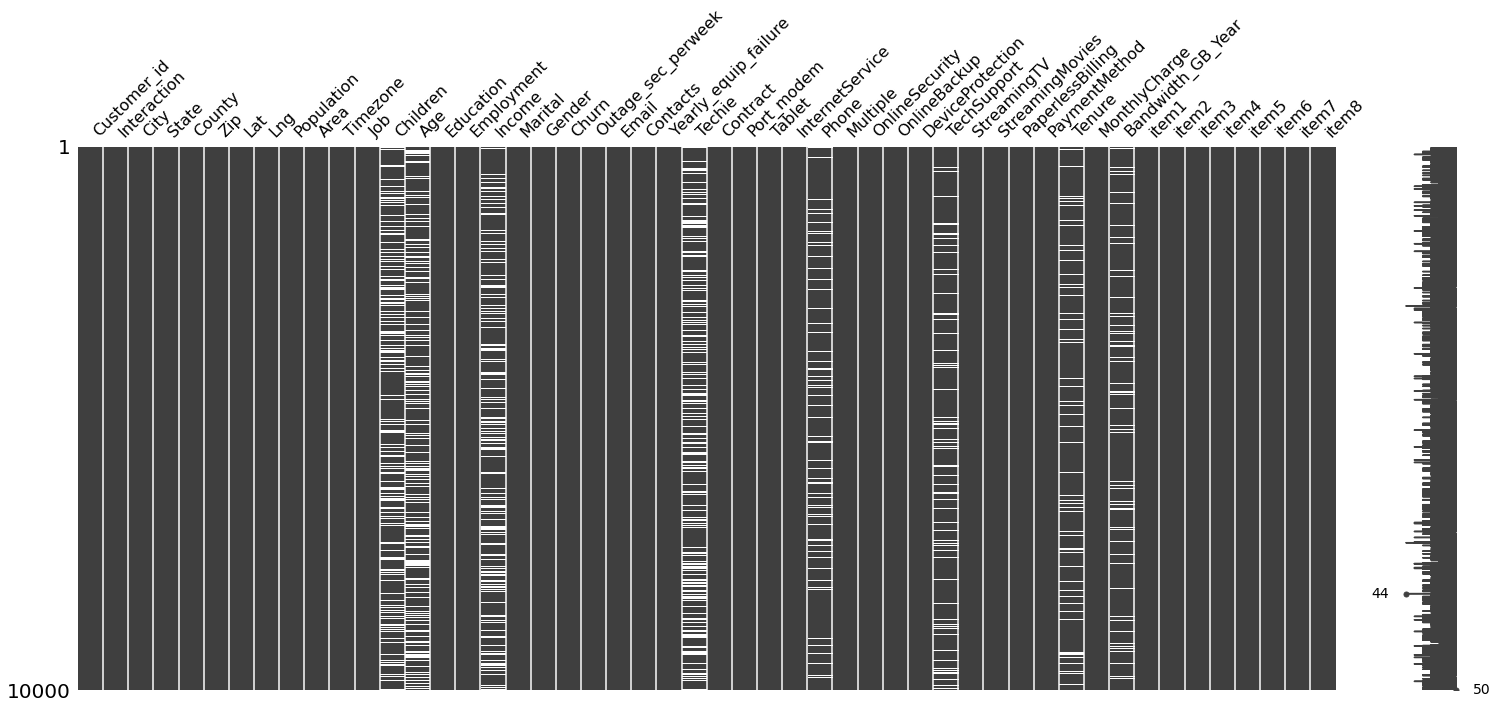

In [13]:
'''Create a missingness matrix'''
msno.matrix(churn)

<AxesSubplot:>

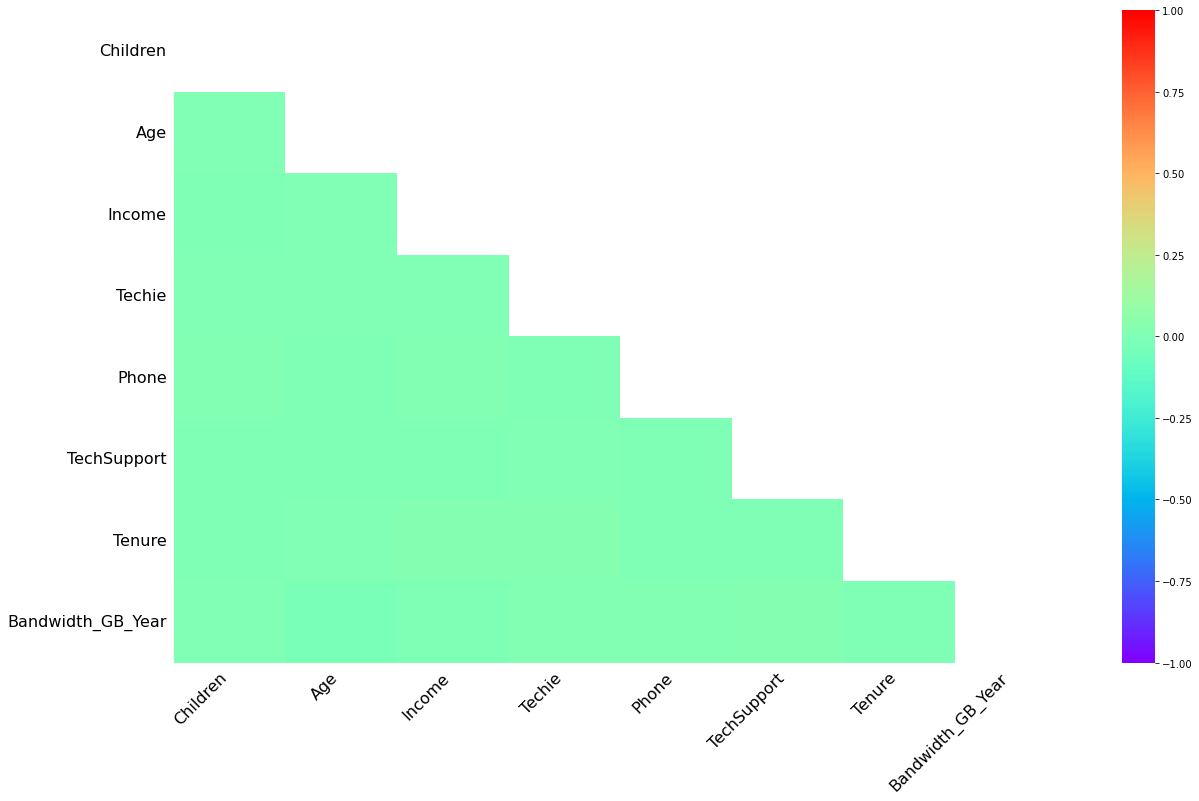

In [14]:
'''Create heatmap to check correlations between missing data points'''
msno.heatmap(churn, cmap='rainbow')

<AxesSubplot:>

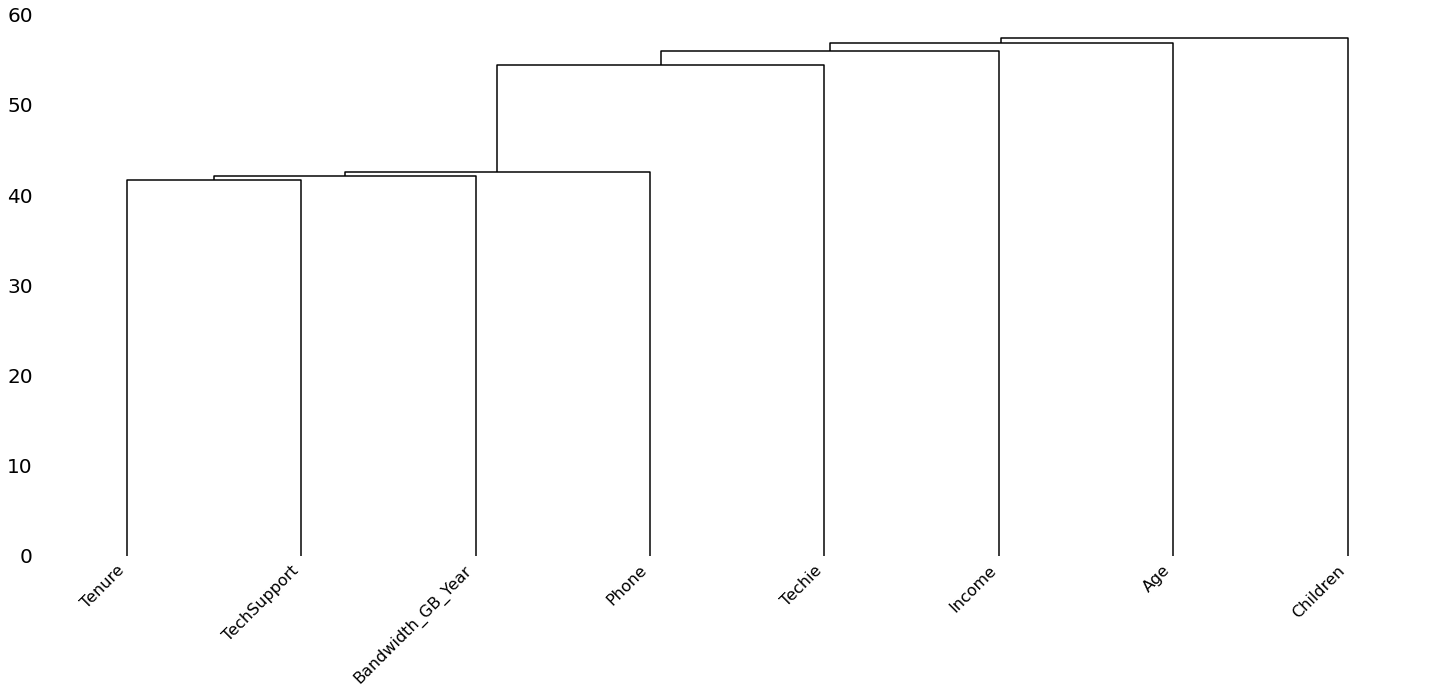

In [15]:
'''Create a dendrogram to verify the heatmap's conclusion that there are no significant correlations missingness'''
msno.dendrogram(churn[churn_null_name], orientation='top')

### Given no correlation between between missingness, we can impute missing values with simple univariate techniques. I will take a look at the distributions of the variables before determining how to impute.

array([[<AxesSubplot:title={'center':'Children'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Tenure'}>],
       [<AxesSubplot:title={'center':'Bandwidth_GB_Year'}>,
        <AxesSubplot:>]], dtype=object)

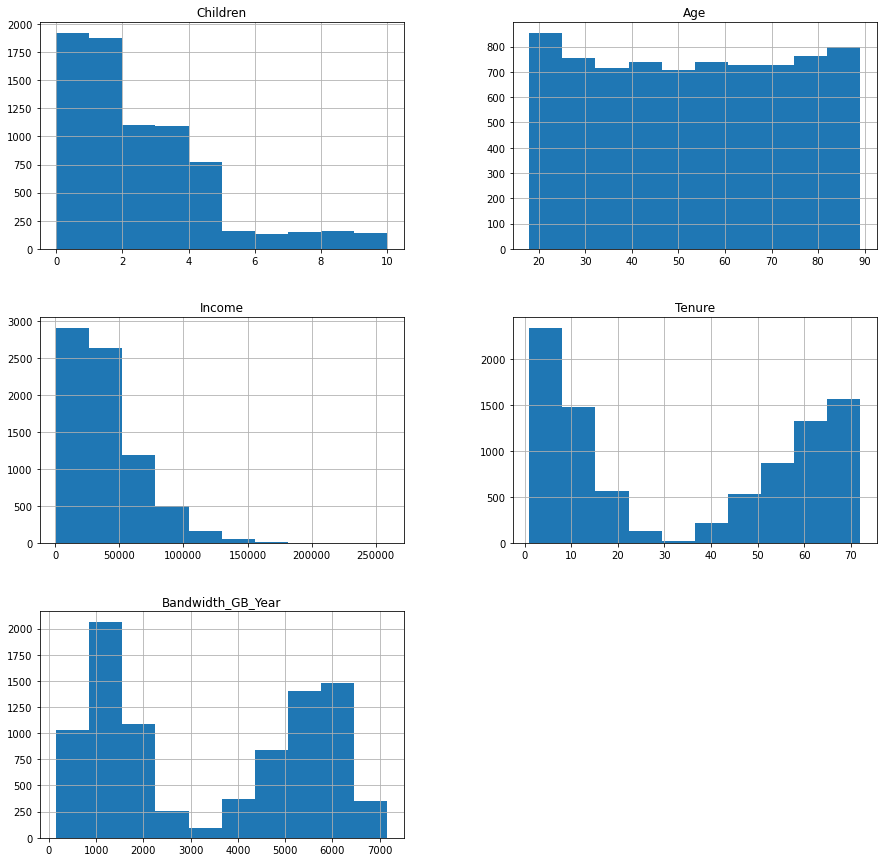

In [16]:
'''Quick histograms to get a rough look at the columns with missing values'''
churn[churn_null_name].hist(figsize = (15,15))

In [17]:
'''The columns with skewed distrubutions will be imputed with the median of their respective columns'''
churn_skew = ['Children', 'Income']
for column in churn_skew:
    churn[column].fillna(churn[column].median(), inplace = True)

In [18]:
'''The columns with normal or consistent distributions will be imputed with the mean of their respective columns'''
churn_normal = ['Age']
for column in churn_normal:
    churn[column].fillna(churn[column].mean(), inplace = True)

array([[<AxesSubplot:title={'center':'Children'}>,
        <AxesSubplot:title={'center':'Age'}>],
       [<AxesSubplot:title={'center':'Income'}>,
        <AxesSubplot:title={'center':'Tenure'}>],
       [<AxesSubplot:title={'center':'Bandwidth_GB_Year'}>,
        <AxesSubplot:>]], dtype=object)

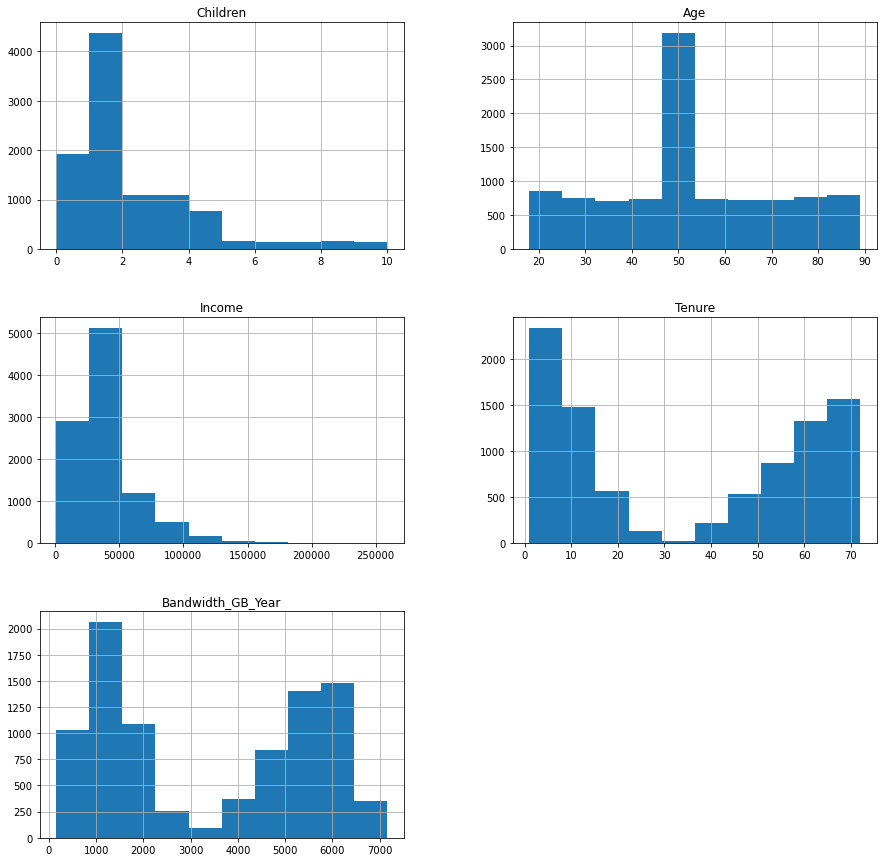

In [19]:
churn[churn_null_name].hist(figsize = (15,15))

In [20]:
'''Create a separate DataFrame for numerical values'''
churn_numerical = churn.select_dtypes(include=['float64'])
churn_numerical.columns

Index(['Children', 'Age', 'Income', 'Outage_sec_perweek', 'Tenure',
       'MonthlyCharge', 'Bandwidth_GB_Year'],
      dtype='object')

In [21]:
'''The columns with bimodal distributions will be imputed with the KNN Imputer'''
knn_imputer = KNN()
churn_knn = churn[churn_numerical.columns].copy(deep=True)
churn_knn.iloc[:,:] = knn_imputer.fit_transform(churn_knn)

Imputing row 1/10000 with 0 missing, elapsed time: 11.163
Imputing row 101/10000 with 0 missing, elapsed time: 11.165
Imputing row 201/10000 with 1 missing, elapsed time: 11.167
Imputing row 301/10000 with 0 missing, elapsed time: 11.168
Imputing row 401/10000 with 1 missing, elapsed time: 11.170
Imputing row 501/10000 with 0 missing, elapsed time: 11.171
Imputing row 601/10000 with 0 missing, elapsed time: 11.172
Imputing row 701/10000 with 0 missing, elapsed time: 11.174
Imputing row 801/10000 with 0 missing, elapsed time: 11.175
Imputing row 901/10000 with 0 missing, elapsed time: 11.177
Imputing row 1001/10000 with 0 missing, elapsed time: 11.178
Imputing row 1101/10000 with 0 missing, elapsed time: 11.180
Imputing row 1201/10000 with 0 missing, elapsed time: 11.181
Imputing row 1301/10000 with 0 missing, elapsed time: 11.183
Imputing row 1401/10000 with 0 missing, elapsed time: 11.184
Imputing row 1501/10000 with 1 missing, elapsed time: 11.185
Imputing row 1601/10000 with 0 missi

In [22]:
'''Replace values in dataframe with imputed values'''
churn['Tenure'].fillna(churn_knn['Tenure'], inplace=True)
churn['Bandwidth_GB_Year'].fillna(churn_knn['Bandwidth_GB_Year'], inplace=True)

In [23]:
'''Replace NaNs in categorical variables'''
churn_cat = ['Techie', 'Phone', 'TechSupport']

for cat in churn_cat:
    churn[cat] = churn[cat].fillna('unknown')
    print(churn[cat].isnull().sum())
    print(churn[cat].unique())

0
['No' 'Yes' 'unknown']
0
['Yes' 'No' 'unknown']
0
['No' 'Yes' 'unknown']


<AxesSubplot:>

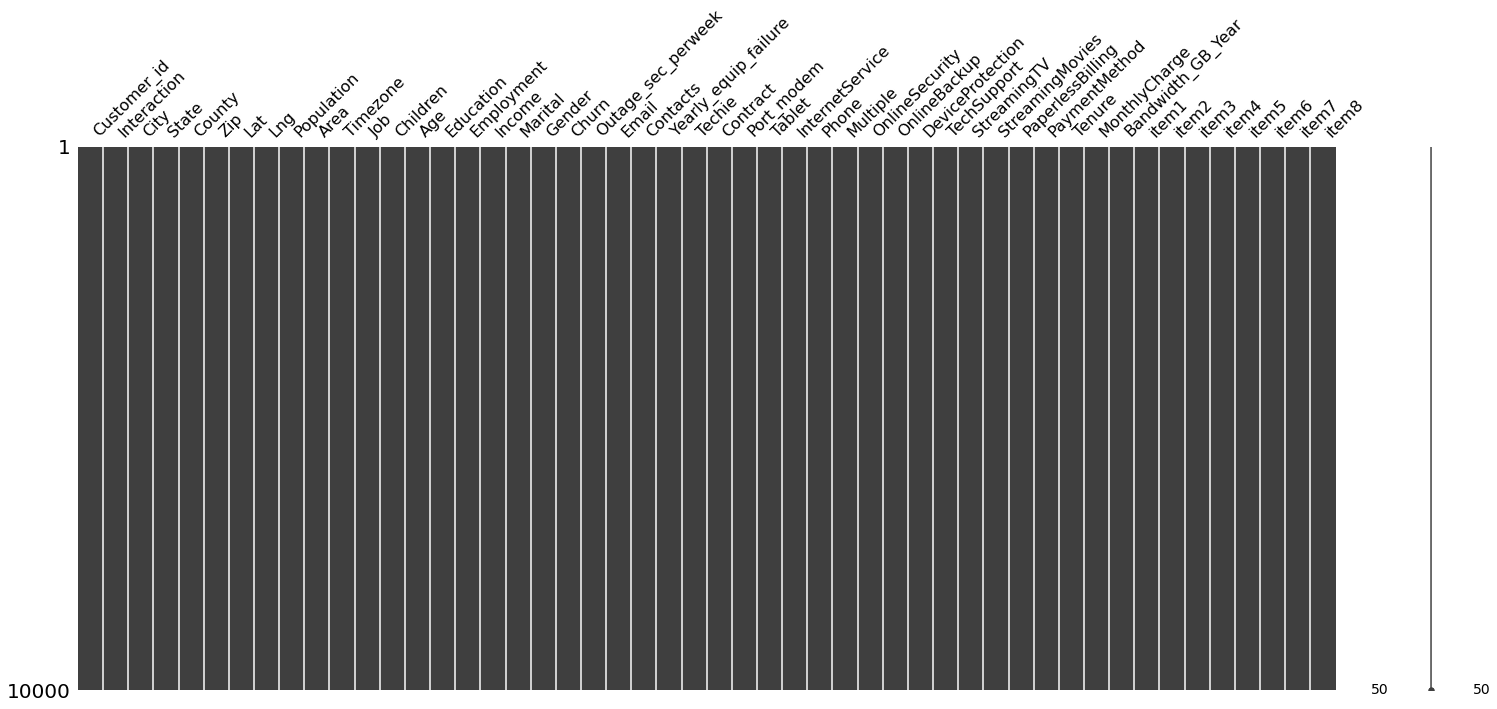

In [24]:
msno.matrix(churn)

### Now that all NaN values are resolved, it's time to handle outliers 

In [25]:
'''Create a separate DataFrame for categorical values'''
churn_categorical = churn.select_dtypes(include=['object'])
churn_categorical.columns

Index(['Customer_id', 'Interaction', 'City', 'State', 'County', 'Zip', 'Lat',
       'Lng', 'Area', 'Timezone', 'Job', 'Education', 'Employment', 'Marital',
       'Gender', 'Churn', 'Techie', 'Contract', 'Port_modem', 'Tablet',
       'InternetService', 'Phone', 'Multiple', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

In [26]:
'''Normalize the dataframe to get them on the same scale to look for outliers'''
churn_outliers = ['Population', 'Children', 'Age','Income', 'Outage_sec_perweek','Email', 'Contacts', \
                  'Yearly_equip_failure', 'Tenure', 'MonthlyCharge', 'Bandwidth_GB_Year',]
churn_std = zscore(churn[churn_outliers])
churn_std

,Population,Children,Age,Income,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Tenure,MonthlyCharge,Bandwidth_GB_Year
0,-0.673405,-0.427079,0.817916,-0.391731,-0.637726,-0.666282,-1.005852,0.946658,-1.072192,-0.060613,-1.172159
1,0.047772,-0.427079,-1.459588,-0.668828,0.079935,-0.005288,-1.005852,0.946658,-1.291586,1.589348,-1.220856
2,-0.417238,1.130655,-0.181964,-0.204845,-0.171849,-0.996779,-1.005852,0.946658,-0.723632,-0.337752,-0.631275
3,0.284537,-0.427079,-0.293062,-0.781148,0.534225,0.986203,1.017588,-0.625864,-0.671765,-1.242158,-0.579606
4,0.110549,-0.946323,1.651149,0.073471,-0.354795,1.316700,1.017588,0.946658,-1.271576,-0.538041,-1.469856
...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.631692,0.611410,0.000000,0.705863,-0.311372,-0.005288,1.017588,-0.625864,1.316805,-0.328789,1.464477
9996,4.670977,1.130655,-0.293062,-0.204845,-0.474994,0.986203,1.017588,-0.625864,1.038352,0.802618,1.081071
9997,-0.647906,-0.427079,0.000000,-0.204845,-0.941598,-0.666282,-1.005852,-0.625864,-0.757147,-0.135125,0.358442
9998,1.788974,-0.427079,-0.793002,-0.872379,0.088748,0.655706,0.005868,-0.625864,1.429578,1.812746,1.444352


<AxesSubplot:>

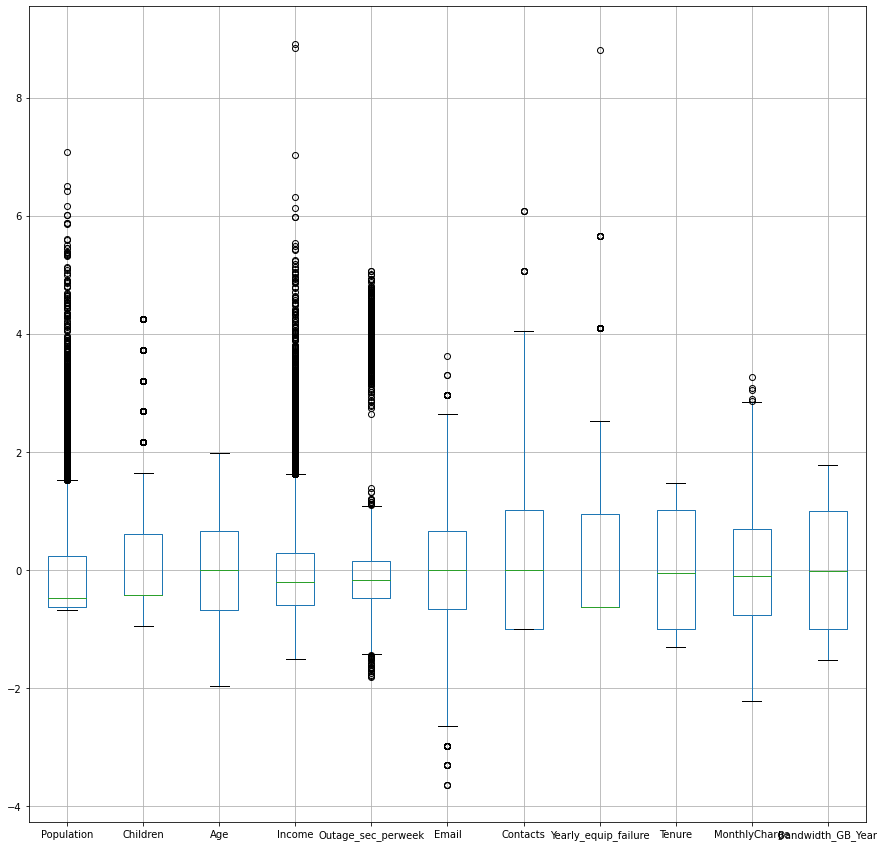

In [27]:
churn_std.boxplot(figsize=(15,15))

In [28]:
churn[churn_numerical.columns].describe()

,Children,Age,Income,Outage_sec_perweek,Tenure,MonthlyCharge,Bandwidth_GB_Year
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.822500,53.275748,38256.017897,11.452955,34.352813,174.076305,3397.092069
std,1.925971,18.003063,24747.872761,7.025921,25.703121,43.335473,2126.571981
min,0.000000,18.000000,740.660000,-1.348571,1.000259,77.505230,155.506715
25%,1.000000,41.000000,23660.790000,8.054362,8.442433,141.071078,1284.610957
50%,1.000000,53.275748,33186.785000,10.202896,32.967942,169.915400,3374.195959
75%,3.000000,65.000000,45504.192500,12.487644,60.377938,203.777441,5504.684171
max,10.000000,89.000000,258900.700000,47.049280,71.999280,315.878600,7158.982000


In [29]:
'''Function to determine outer fences of variables'''
def fences(df, variable_name):    
    q1 = df[variable_name].quantile(0.25)
    q3 = df[variable_name].quantile(0.75)
    iqr = q3-q1
    outer_fence = 3*iqr
    outer_fence_le = q1-outer_fence
    outer_fence_ue = q3+outer_fence
    return outer_fence_le, outer_fence_ue

In [30]:
'''Compare outer fences to quantile values, minumum and maximum values'''
for var in churn_outliers:
    outer_fence_le, outer_fence_ue = fences(churn, var)
    print('Lower end outer fence: ', var, outer_fence_le)
    print('Upper end outer fence: ', var, outer_fence_ue, '\n')

    print('The minimum value in ', var, 'is', churn[var].min())
    print('.1% quantile: ', var, churn[var].quantile(0.001))
    print('1% quantile:   ', var, churn[var].quantile(0.1))
    print('2.5% quantile: ', var, churn[var].quantile(0.025))
    print('5% quantile:   ', var, churn[var].quantile(0.05))
    print('7.5% quantile: ', var, churn[var].quantile(0.075))
    print('10% quantile of:', var, churn[var].quantile(0.10))       
    print('-----')
    print('90% quantile of:', var, churn[var].quantile(0.90))       
    print('92.5% quantile: ', var, churn[var].quantile(0.925))      
    print('95% quantile:   ', var, churn[var].quantile(0.95))       
    print('97.5% quantile: ', var, churn[var].quantile(0.975))      
    print('99% quantile:   ', var, churn[var].quantile(0.99))       
    print('99.9% quantile: ', var, churn[var].quantile(0.999))
    print('The maximum value in ', var, 'is', churn[var].max(), '\n')

Lower end outer fence:  Population -36552.0
Upper end outer fence:  Population 50458.0 

The minimum value in  Population is 0
.1% quantile:  Population 0.0
1% quantile:    Population 211.0
2.5% quantile:  Population 42.97500000000002
5% quantile:    Population 102.95000000000005
7.5% quantile:  Population 160.0
10% quantile of: Population 211.0
-----
90% quantile of: Population 30558.000000000007
92.5% quantile:  Population 35281.85000000003
95% quantile:    Population 40770.399999999994
97.5% quantile:  Population 51082.37499999999
99% quantile:    Population 62429.0
99.9% quantile:  Population 90517.15800000002
The maximum value in  Population is 111850 

Lower end outer fence:  Children -5.0
Upper end outer fence:  Children 9.0 

The minimum value in  Children is 0.0
.1% quantile:  Children 0.0
1% quantile:    Children 0.0
2.5% quantile:  Children 0.0
5% quantile:    Children 0.0
7.5% quantile:  Children 0.0
10% quantile of: Children 0.0
-----
90% quantile of: Children 4.0
92.5% qu

In [31]:
'''Drop population because the data has many outliers above the distribution and many values that are so low it is
difficult to believe that they are accurate.'''
churn=churn.drop('Population', axis = 1)
churn.columns

Index(['Customer_id', 'Interaction', 'City', 'State', 'County', 'Zip', 'Lat',
       'Lng', 'Area', 'Timezone', 'Job', 'Children', 'Age', 'Education',
       'Employment', 'Income', 'Marital', 'Gender', 'Churn',
       'Outage_sec_perweek', 'Email', 'Contacts', 'Yearly_equip_failure',
       'Techie', 'Contract', 'Port_modem', 'Tablet', 'InternetService',
       'Phone', 'Multiple', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'PaymentMethod', 'Tenure', 'MonthlyCharge',
       'Bandwidth_GB_Year', 'item1', 'item2', 'item3', 'item4', 'item5',
       'item6', 'item7', 'item8'],
      dtype='object')

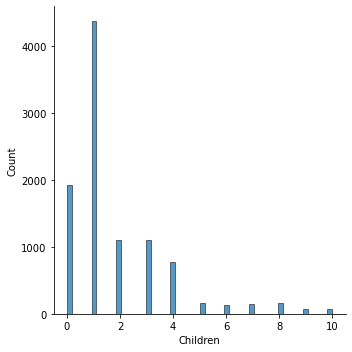

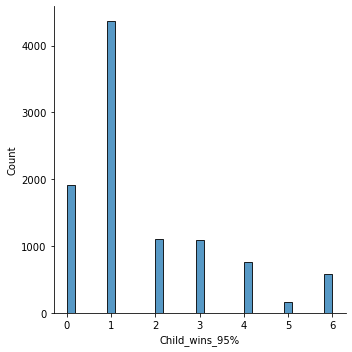

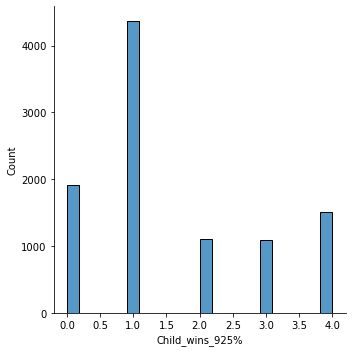

In [32]:
'''winsorize the children column'''
var = 'Children'

#Create copy of df
churn_win = churn.copy(deep=True)

#Winsorize on right-tail
churn_win['Child_wins_95%'] = winsorize(churn[var], limits=(.01, 0.05))
churn_win['Child_wins_925%'] = winsorize(churn[var], limits=(.01, 0.075))

churn_win.describe()

#Distribution plot: Crime rate per capita by town
sns.displot(churn[var])

#New distribution plots 
sns.displot(churn_win['Child_wins_95%'])
sns.displot(churn_win['Child_wins_925%'])

<AxesSubplot:>

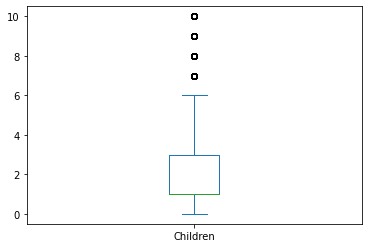

In [33]:
'''Replace child column with child_wins_95_column'''
churn['Children'] = churn_win['Child_wins_95%']
churn_win['Children'].plot.box()

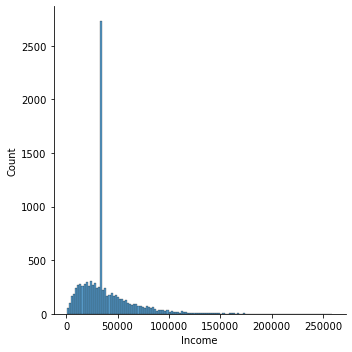

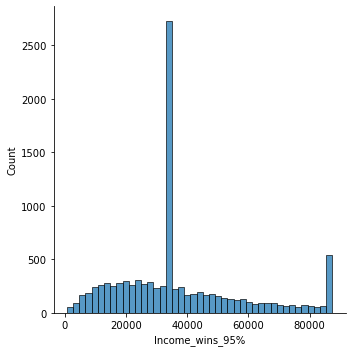

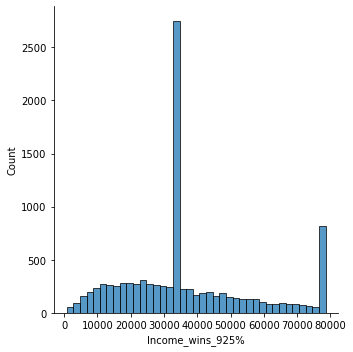

In [34]:
'''winsorize the Income column'''
var = 'Income'

#Create copy of df
churn_win = churn.copy(deep=True)

#Winsorize on right-tail
churn_win['Income_wins_95%'] = winsorize(churn[var], limits=(0, 0.05))
churn_win['Income_wins_925%'] = winsorize(churn[var], limits=(0, 0.075))

churn_win.describe()

#Distribution plot: Crime rate per capita by town
sns.displot(churn[var])

#New distribution plots 
sns.displot(churn_win['Income_wins_95%'])
sns.displot(churn_win['Income_wins_925%'])

<AxesSubplot:>

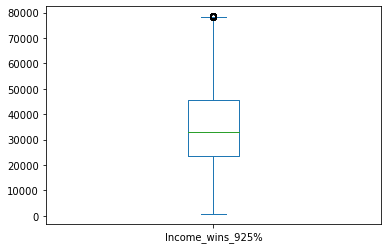

In [35]:
'''Replace income column with income_wins_925_column'''
churn['Income'] = churn_win['Income_wins_925%']
churn_win['Income_wins_925%'].plot.box()

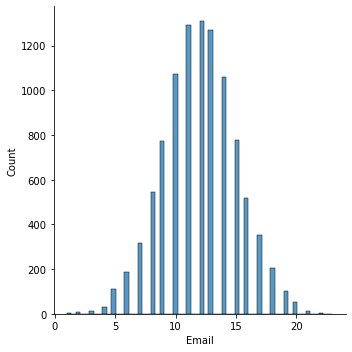

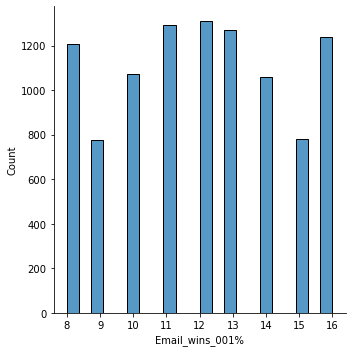

In [36]:
'''winsorize the Email column'''
var = 'Email'

#Create copy of df
churn_win = churn.copy(deep=True)

#Winsorize on right-tail
churn_win['Email_wins_001%'] = winsorize(churn[var], limits=(.075, .075))

churn_win.describe()

#Distribution plot: Crime rate per capita by town
sns.displot(churn[var])

#New distribution plots 
sns.displot(churn_win['Email_wins_001%'])


<AxesSubplot:>

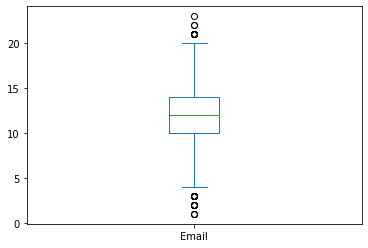

In [37]:
'''Replace email column with email_wins_925_column'''
churn['Email'] = churn_win['Email_wins_001%']
churn_win['Email'].plot.box()

### Now that outliers have been resolved, we will examine feature deduction with PCA

In [38]:
churn.Education.unique()

array(["Master's Degree", 'Regular High School Diploma',
       'Doctorate Degree', 'No Schooling Completed', "Associate's Degree",
       "Bachelor's Degree", 'Some College, Less than 1 Year',
       'GED or Alternative Credential',
       'Some College, 1 or More Years, No Degree',
       '9th Grade to 12th Grade, No Diploma',
       'Nursery School to 8th Grade', 'Professional School Degree'],
      dtype=object)

In [39]:
scale_mapper = {'No Schooling Completed':1, 'Nursery School to 8th Grade':2, '9th Grade to 12th Grade, No Diploma':3,
                'GED or Alternative Credential':4, 'Regular High School Diploma':5, 'Professional School Degree':6,
                'Some College, Less than 1 Year':7, 'Some College, 1 or More Years, No Degree':8, 'Associate\'s Degree':9, 
                "Bachelor's Degree":10, "Master's Degree":11, 'Doctorate Degree':12
               }

churn["Degree_Scale"] = churn["Education"].replace(scale_mapper)
print(churn.Degree_Scale)

0       11
1        5
2        5
3       12
4       11
        ..
9995     7
9996     5
9997     2
9998    10
9999     4
Name: Degree_Scale, Length: 10000, dtype: int64


In [40]:
var_cat = ['Employment', 'Marital','Gender', 'Churn', 'Contract', 'Port_modem', 'Tablet',  'Multiple', 'Techie', 
           'InternetService', 'Phone', 'TechSupport', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
           'StreamingTV', 'StreamingMovies', 'PaperlessBilling', 
           'PaymentMethod']
for var in var_cat:
    ord_enc = OrdinalEncoder()
    var_code = var+"_code"
    churn[var_code] = ord_enc.fit_transform(churn[[var]])
    print(churn[var_code])
    churn[[var, var_code]].head(11)

0       1.0
1       2.0
2       3.0
3       2.0
4       3.0
       ... 
9995    2.0
9996    1.0
9997    0.0
9998    0.0
9999    0.0
Name: Employment_code, Length: 10000, dtype: float64
0       4.0
1       1.0
2       4.0
3       1.0
4       3.0
       ... 
9995    1.0
9996    0.0
9997    2.0
9998    3.0
9999    2.0
Name: Marital_code, Length: 10000, dtype: float64
0       1.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
9995    1.0
9996    1.0
9997    0.0
9998    1.0
9999    1.0
Name: Gender_code, Length: 10000, dtype: float64
0       0.0
1       1.0
2       0.0
3       0.0
4       1.0
       ... 
9995    0.0
9996    0.0
9997    0.0
9998    0.0
9999    0.0
Name: Churn_code, Length: 10000, dtype: float64
0       1.0
1       0.0
2       2.0
3       2.0
4       0.0
       ... 
9995    0.0
9996    2.0
9997    0.0
9998    2.0
9999    0.0
Name: Contract_code, Length: 10000, dtype: float64
0       1.0
1       0.0
2       1.0
3       0.0
4       1.0
       ... 
9995    1.0
9996 

In [48]:
'''Fit PCA model'''

'''Scale the original data'''
scaler = StandardScaler()
churn_std = scaler.fit_transform(churn[churn_numerical.columns])

pca = PCA(n_components=6)
pca.fit(churn_std)
print(pca.explained_variance_ratio_.cumsum())

[0.27579686 0.43727225 0.5826781  0.7253863  0.86617298 0.99010822]


Text(0, 0.5, 'Variance Explained')

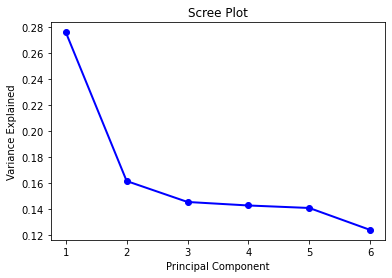

In [49]:
'''Create a scree plot of pca components'''
pca_values = np.arange(pca.n_components_) + 1
plt.plot(pca_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

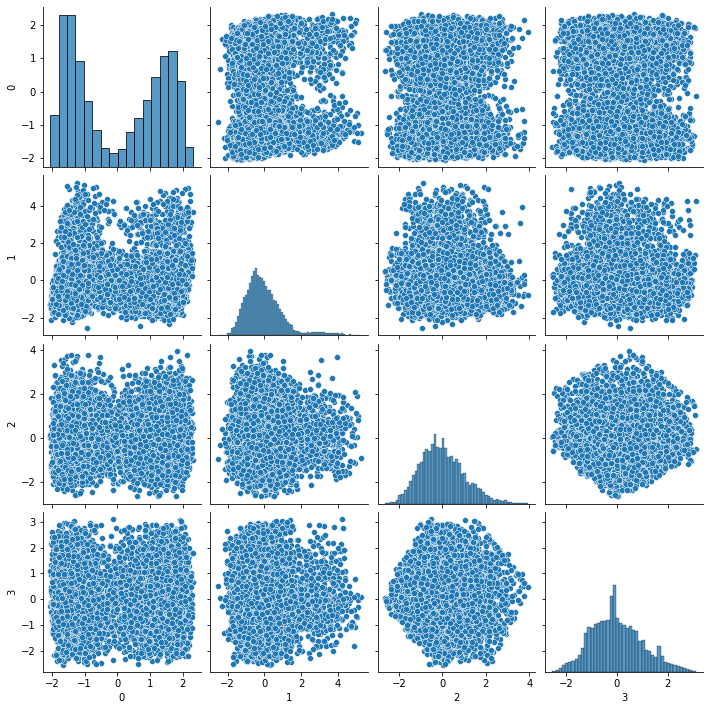

In [77]:
sns.pairplot(pd.DataFrame(pca.fit_transform(churn_std)))

([<matplotlib.axis.XTick at 0x1aa1366e550>,
 [Text(0, 1, 'Children'),
  Text(1, 1, 'Age'),
  Text(2, 1, 'Income'),
  Text(3, 1, 'Outage_sec_perweek'),
  Text(4, 1, 'Tenure'),
  Text(5, 1, 'MonthlyCharge'),
  Text(6, 1, 'Bandwidth_GB_Year')])

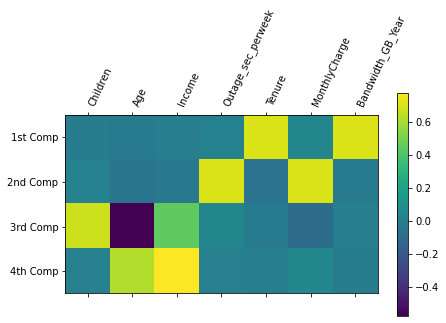

In [79]:
pl.matshow(pca.components_,cmap='viridis')
pl.yticks([0,1,2,3,],['1st Comp','2nd Comp','3rd Comp', '4th Comp'],fontsize=10)
pl.colorbar()
pl.xticks(range(len(churn_numerical.columns)),churn[churn_numerical.columns],rotation=65,ha='left')

In [84]:
churn.to_csv(r'C:\Users\scott\Data Projects\MSDA Projects\D206_Data_Cleaning\churn.csv', sep=',')